In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl

sns.set()

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn import metrics


In [6]:
df_1=pd.read_csv('PAR_NYC.csv')
df_2 = pd.read_csv("PAR_SVO.csv")
df_3 = pd.read_csv("SVO_NYC.csv")
df_4 = pd.read_csv("SVO_RUH.csv")
df_5 = pd.read_csv("NYC_PAR.csv")
df_6 = pd.read_csv("NYC_SVO.csv")
df_7 = pd.read_csv("RUH_NYC.csv")
df_8 = pd.read_csv("RUH_PAR.csv")
df_9 = pd.read_csv("RUH_SVO.csv")
df_10 = pd.read_csv("SVO_PAR.csv")
df_11 = pd.read_csv("PAR_RUH.csv")
df_12 = pd.read_csv("NYC_RUH.csv")


In [7]:
print(f"{df_1['Source'][0]} => {df_1['Destination'][0]} route has {df_1.shape[0]} trips")
print(f"{df_2['Source'][0]} => {df_2['Destination'][0]} route has {df_2.shape[0]} trips")
print(f"{df_3['Source'][0]} => {df_3['Destination'][0]} route has {df_3.shape[0]} trips")
print(f"{df_4['Source'][0]} => {df_4['Destination'][0]} route has {df_4.shape[0]} trips")
print(f"{df_5['Source'][0]} => {df_5['Destination'][0]} route has {df_5.shape[0]} trips")
print(f"{df_6['Source'][0]} => {df_6['Destination'][0]} route has {df_6.shape[0]} trips")
print(f"{df_7['Source'][0]} => {df_7['Destination'][0]} route has {df_7.shape[0]} trips")
print(f"{df_8['Source'][0]} => {df_8['Destination'][0]} route has {df_8.shape[0]} trips")
print(f"{df_9['Source'][0]} => {df_9['Destination'][0]} route has {df_9.shape[0]} trips")
print(f"{df_10['Source'][0]} => {df_10['Destination'][0]} route has {df_10.shape[0]} trips")
print(f"{df_11['Source'][0]} => {df_11['Destination'][0]} route has {df_11.shape[0]} trips")
print(f"{df_12['Source'][0]} => {df_12['Destination'][0]} route has {df_12.shape[0]} trips")

PAR => NYC route has 14881 trips
PAR => SVO route has 2403 trips
SVO => NYC route has 4202 trips
SVO => RUH route has 2235 trips
NYC => PAR route has 5334 trips
NYC => SVO route has 1905 trips
RUH => NYC route has 7279 trips
RUH => PAR route has 553 trips
RUH => SVO route has 2725 trips
SVO => PAR route has 3314 trips
PAR => RUH route has 7327 trips
NYC => RUH route has 3205 trips


# Defining Function To clean Data

In [8]:
# convert duration to numerical format in minutes
def clean_duration(duration):
    duration = list(duration)
    duration_hours = []
    duration_mins = []
    for i in range(len(duration)):
        duration_hours.append(int(duration[i].split(sep = "h")[0])) # Extract hours from duration
        duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1])) # Extracts only minutes from duration

    d = []
    for i in range(len(duration)):
        d.append(duration_hours[i]*60+duration_mins[i])
        
    return d

# convert price to numerical format in USD
def clean_price(price):
    price = price.str.replace(',','',regex=True)
    price = price.str.replace('SAR','',regex=True)
    price = price.str.strip()
    price = round(pd.to_numeric(price)/3.75,2)
    return price

# convert date to datetime format
def clean_date(date):
    date = pd.to_datetime(date)
    return date

# get price quantile to deal with outliers
def get_price_quantile(price):
    Q1 = price.quantile(0.25)
    Q3 = price.quantile(0.75)
    IQR = Q3 - Q1
    lower_lim = Q1 - 1.5 * IQR
    upper_lim = Q3 + 1.5 * IQR
    return (lower_lim,upper_lim)

# get average of each airline
def get_avg_per_airline(x):
    # average for trips with multiple airlines
    multiple_airlines = x[x["Airline"].str.contains(",")]
    b = list(multiple_airlines["Airline"].str.split(","))
    d = [] # Airline 1
    e = [] # Airline 2
    for i in range(len(b)):
        d.append(b[i][0])
        e.append(b[i][1])
    for i in range(len(e)):
        e[i] = e[i].strip()
    m_airlines = list(set(d)) + list(set(e))
    column_names = ["Airline", "Average Price"]
    t_ = pd.DataFrame(columns = column_names)
    for airline in m_airlines:
        t = pd.DataFrame(x[x["Airline"].str.contains(airline)]["Airline"])
        t["Average Price"] = x[x["Airline"].str.contains(airline)]["Price"].mean()
        t_ = t_.append(t)
    t__ = t_.groupby("Airline",as_index = False)["Average Price"].mean()
    k = multiple_airlines.copy()
    k = k.merge(t__, on = "Airline", how = "left")
    
    # average for trips with single airlines
    single_airlines = x[~x["Airline"].str.contains(",")]
    avg_per_airline = single_airlines.groupby("Airline", as_index = False)["Price"].mean()
    avg_per_airline = avg_per_airline.rename(columns={"Price" : "Average Price"})
    temp = single_airlines.copy()
    temp = temp.merge(avg_per_airline, on='Airline', how ="left")
    
    temp_1 = temp.groupby("Airline", as_index = False)["Average Price"].mean()
    k_1 = k.groupby("Airline", as_index = False)["Average Price"].mean()
    k_temp = pd.concat([k_1,temp_1])
    y = x.merge(k_temp, on = "Airline")
    
    return y

In [9]:
dfs_raw = [df_1,df_2,df_3,df_4,df_5,df_6,df_7,df_8,df_9,df_10,df_11,df_12]

In [10]:
dfs_raw

[                       Airline Source Destination  Duration Total stops  \
 0             TAP AIR PORTUGAL    PAR         NYC  12h 50m      1 stop    
 1                       Iberia    PAR         NYC   8h 40m     nonstop    
 2      Air Transat, Air Canada    PAR         NYC  11h 39m      1 stop    
 3            Brussels Airlines    PAR         NYC   8h 20m     nonstop    
 4                   Air France    PAR         NYC   8h 25m     nonstop    
 ...                        ...    ...         ...       ...         ...   
 14876                  Finnair    PAR         NYC  13h 00m      1 stop    
 14877           Etihad Airways    PAR         NYC  23h 40m      1 stop    
 14878               Aeromexico    PAR         NYC  20h 15m      1 stop    
 14879           Cathay Pacific    PAR         NYC  29h 15m      1 stop    
 14880           Cathay Pacific    PAR         NYC  30h 30m      1 stop    
 
              Price        Date  
 0       1,423 SAR   2022-02-01  
 1       1,547 SAR

In [11]:
# cleaning the data
dfs = []
for df in dfs_raw:
    df.drop_duplicates() # drop duplicate rows
    df["Duration"] = clean_duration(df["Duration"]) # convert duration to numerical minutes format
    df["Price"] = clean_price(df["Price"]) # convert price to numerical format in USD
    df["Date"] = clean_date(df["Date"]) # convert date to datetime format
    dfs.append(get_avg_per_airline(df)) # get average per airline

# Handling Outliers

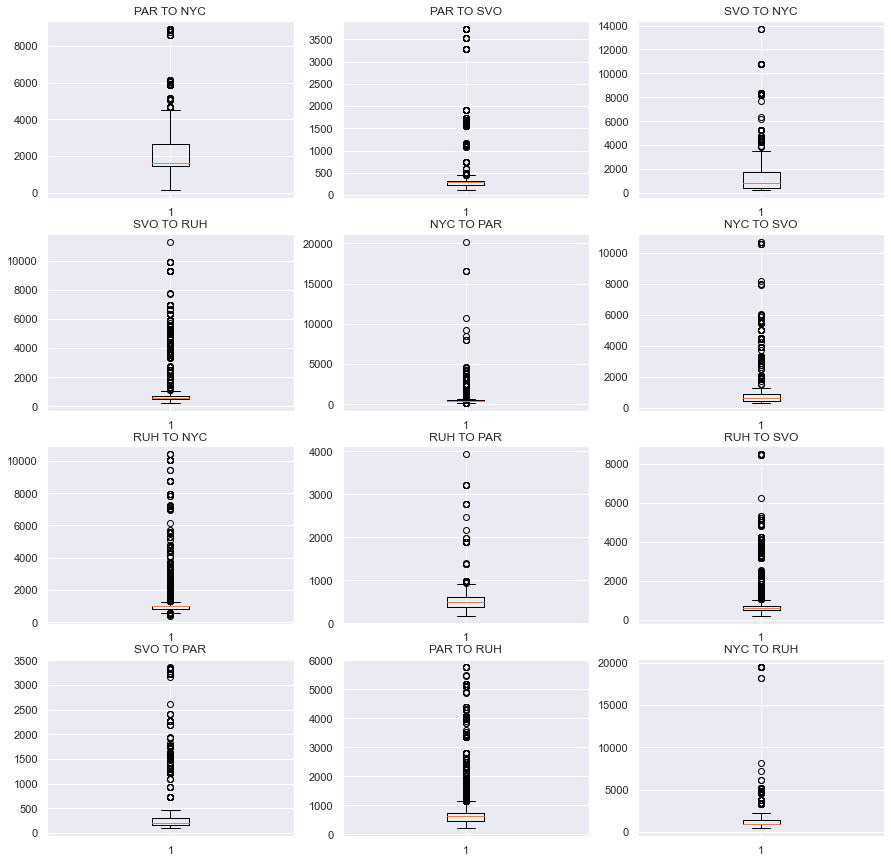

In [12]:
k=0
figure, axis = plt.subplots(4, 3, figsize=(15,15))
for i in range(4):
    for j in range(3):
        axis[i,j].boxplot(dfs[k]['Price'])
        axis[i,j].set_title(f"{dfs[k]['Source'][0]} TO {dfs[k]['Destination'][0]}")
        k += 1

It is apparent that all routes have outliers, so we will deal with them by IQR

In [13]:
# get quantile to deal with outliers
lower = []
upper = []
for df in dfs:
    x = get_price_quantile(df['Price'])
    lower.append(x[0])
    upper.append(x[1])

In [14]:
# drop outliers
k = 0
for df in dfs:
    low = df['Price'] < lower[k]
    up = df['Price'] > upper[k]
    df['Price'] = df['Price'][~(low|up)]
    df.dropna(inplace=True)
    df.reset_index(drop = True,inplace=True)
    k+=1

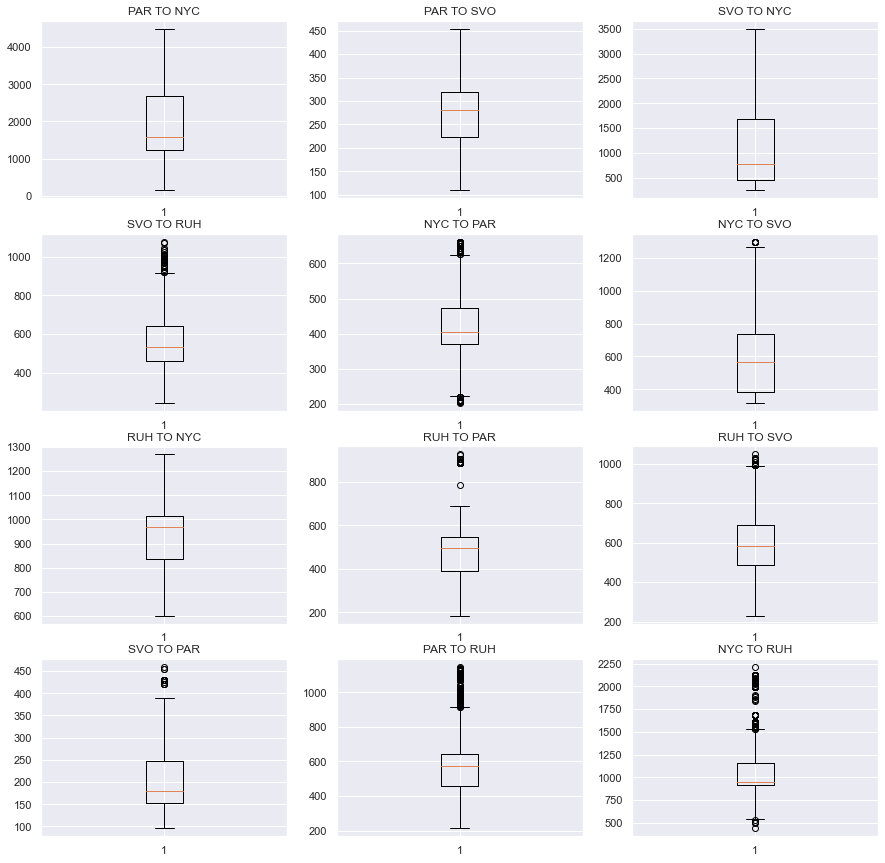

In [15]:
# boxplot for each route after dealing with outliers
k=0
figure, axis = plt.subplots(4, 3, figsize=(15,15))
for i in range(4):
    for j in range(3):
        axis[i,j].boxplot(dfs[k]['Price'])
        axis[i,j].set_title(f"{dfs[k]['Source'][0]} TO {dfs[k]['Destination'][0]}")
        k += 1

Now the data is much better, the total dropped data is 5,266 rows out of 55,363.

In [16]:
# concat all routes into one dataframe
df = pd.concat(dfs)
df

,Airline,Source,Destination,Duration,Total stops,Price,Date,Average Price
0,TAP AIR PORTUGAL,PAR,NYC,770,1 stop,379.47,2022-02-01,441.343760
1,TAP AIR PORTUGAL,PAR,NYC,770,1 stop,379.47,2022-02-01,441.343760
2,TAP AIR PORTUGAL,PAR,NYC,810,1 stop,379.47,2022-02-01,441.343760
3,TAP AIR PORTUGAL,PAR,NYC,890,1 stop,379.47,2022-02-01,441.343760
4,TAP AIR PORTUGAL,PAR,NYC,1030,1 stop,379.47,2022-02-01,441.343760
...,...,...,...,...,...,...,...,...
3046,"SAS, Pegasus Airlines",NYC,RUH,1300,2 stops,930.40,2022-04-13,838.732500
3047,"Qatar Airways, SAUDIA",NYC,RUH,1420,2 stops,1018.40,2022-04-13,1972.813714
3048,"Qatar Airways, MEA",NYC,RUH,1415,2 stops,1049.87,2022-04-13,1133.548015
3049,"Emirates, Turkish Airlines",NYC,RUH,1100,2 stops,1053.60,2022-04-13,1023.900221


we have 50097 rows and 8 columns in our dataset.

In [17]:
# check for null values
df.isnull().sum()

Airline          0
Source           0
Destination      0
Duration         0
Total stops      0
Price            0
Date             0
Average Price    0
dtype: int64

there is no missing values prersent in our dataset.

# Calculate categorical Data

In [18]:
# the Airline column will be replaced by the average price per airline.
df.drop("Airline", axis = 1, inplace = True)

In [19]:
df["Source"].value_counts()

PAR    23054
NYC     9411
RUH     9140
SVO     8492
Name: Source, dtype: int64

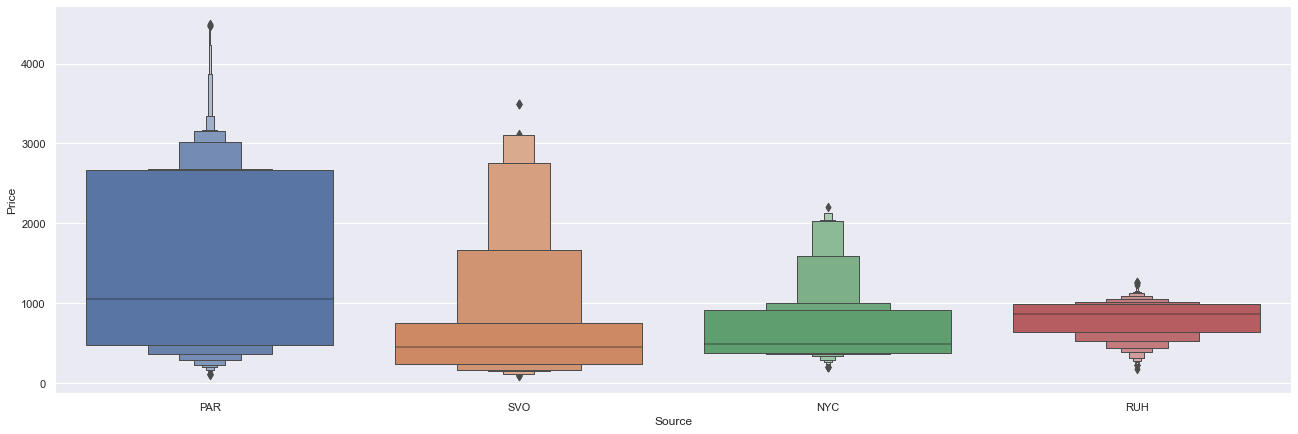

In [20]:
sns.catplot(y = "Price", x= "Source", data = df.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)

As we can see the correlation between source and price in the above figure.

In [21]:
# performing OneHotEncoding on Source since it's nominal categorical data  
source =df[["Source"]]
source =pd.get_dummies(source, drop_first=True)
source.head()

,Source_PAR,Source_RUH,Source_SVO
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [22]:
df["Destination"].value_counts()

NYC    24926
RUH    11046
PAR     8042
SVO     6083
Name: Destination, dtype: int64

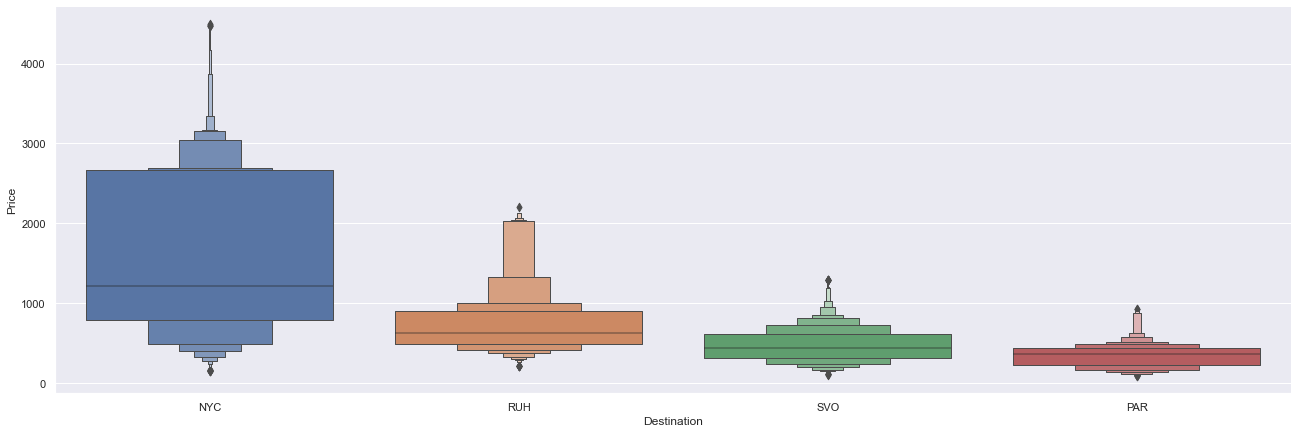

In [23]:
sns.catplot(y = "Price", x= "Destination", data = df.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)

as we can see the realtion between the Destination and price in above figure.

In [24]:
# performing OneHotEncoding on Destination since it's nominal categorical data
destination = df[["Destination"]]
destination = pd.get_dummies(destination, drop_first=True)
destination.head()

,Destination_PAR,Destination_RUH,Destination_SVO
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [25]:
# total stops
print(df["Total stops"].value_counts())
df["Total stops"].unique()

1 stop      27466
2 stops     18665
3 stops      1988
nonstop      1978
Name: Total stops, dtype: int64


array(['1 stop ', '2 stops ', 'nonstop ', '3 stops '], dtype=object)

In [26]:
# performing LabelEncoder on Total stops since it's ordinal categorical data
df.replace({"nonstop ":0, "1 stop ": 1, "2 stops ": 2, "3 stops ":3}, inplace=True)

In [27]:
final_df = pd.concat([df,source,destination], axis=1).reset_index(drop = True)

In [28]:
final_df

,Source,Destination,Duration,Total stops,Price,Date,Average Price,Source_PAR,Source_RUH,Source_SVO,Destination_PAR,Destination_RUH,Destination_SVO
0,PAR,NYC,770,1,379.47,2022-02-01,441.343760,1,0,0,0,0,0
1,PAR,NYC,770,1,379.47,2022-02-01,441.343760,1,0,0,0,0,0
2,PAR,NYC,810,1,379.47,2022-02-01,441.343760,1,0,0,0,0,0
3,PAR,NYC,890,1,379.47,2022-02-01,441.343760,1,0,0,0,0,0
4,PAR,NYC,1030,1,379.47,2022-02-01,441.343760,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50092,NYC,RUH,1300,2,930.40,2022-04-13,838.732500,0,0,0,0,1,0
50093,NYC,RUH,1420,2,1018.40,2022-04-13,1972.813714,0,0,0,0,1,0
50094,NYC,RUH,1415,2,1049.87,2022-04-13,1133.548015,0,0,0,0,1,0
50095,NYC,RUH,1100,2,1053.60,2022-04-13,1023.900221,0,0,0,0,1,0


Now we have 50097 rows and 13 columns in our dataset.

In [29]:
final_df.drop(["Source","Destination","Date"], axis=1, inplace=True)

In [30]:
final_df

,Duration,Total stops,Price,Average Price,Source_PAR,Source_RUH,Source_SVO,Destination_PAR,Destination_RUH,Destination_SVO
0,770,1,379.47,441.343760,1,0,0,0,0,0
1,770,1,379.47,441.343760,1,0,0,0,0,0
2,810,1,379.47,441.343760,1,0,0,0,0,0
3,890,1,379.47,441.343760,1,0,0,0,0,0
4,1030,1,379.47,441.343760,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
50092,1300,2,930.40,838.732500,0,0,0,0,1,0
50093,1420,2,1018.40,1972.813714,0,0,0,0,1,0
50094,1415,2,1049.87,1133.548015,0,0,0,0,1,0
50095,1100,2,1053.60,1023.900221,0,0,0,0,1,0


Finally we have 50097 rows and 10 columns in our dataset.

In [31]:
final_df.shape

(50097, 10)

In [32]:
final_df.isnull().sum()

Duration           0
Total stops        0
Price              0
Average Price      0
Source_PAR         0
Source_RUH         0
Source_SVO         0
Destination_PAR    0
Destination_RUH    0
Destination_SVO    0
dtype: int64

there is no missing value present in our dataset

In [33]:
final_df.info

<bound method DataFrame.info of        Duration  Total stops    Price  Average Price  Source_PAR  Source_RUH  \
0           770            1   379.47     441.343760           1           0   
1           770            1   379.47     441.343760           1           0   
2           810            1   379.47     441.343760           1           0   
3           890            1   379.47     441.343760           1           0   
4          1030            1   379.47     441.343760           1           0   
...         ...          ...      ...            ...         ...         ...   
50092      1300            2   930.40     838.732500           0           0   
50093      1420            2  1018.40    1972.813714           0           0   
50094      1415            2  1049.87    1133.548015           0           0   
50095      1100            2  1053.60    1023.900221           0           0   
50096      1115            3  1139.73    1023.714222           0           0   

       

In [34]:
final_df.skew()

Duration           0.303469
Total stops        0.333617
Price              1.295022
Average Price      1.123132
Source_PAR         0.159763
Source_RUH         1.644504
Source_SVO         1.761707
Destination_PAR    1.849554
Destination_RUH    1.348435
Destination_SVO    2.318211
dtype: float64

In [35]:
final_df.columns

Index(['Duration', 'Total stops', 'Price', 'Average Price', 'Source_PAR',
       'Source_RUH', 'Source_SVO', 'Destination_PAR', 'Destination_RUH',
       'Destination_SVO'],
      dtype='object')

In [36]:
final_df.describe()

,Duration,Total stops,Price,Average Price,Source_PAR,Source_RUH,Source_SVO,Destination_PAR,Destination_RUH,Destination_SVO
count,50097.000000,50097.000000,50097.000000,50097.000000,50097.000000,50097.000000,50097.000000,50097.000000,50097.000000,50097.000000
mean,940.056670,1.412460,1039.301158,1134.103886,0.460187,0.182446,0.169511,0.160529,0.220492,0.121424
std,289.148655,0.632991,858.355940,796.401153,0.498417,0.386216,0.375207,0.367099,0.414583,0.326623
min,215.000000,0.000000,96.000000,129.113636,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,730.000000,1.000000,432.800000,532.747689,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,945.000000,1.000000,685.330000,926.810466,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1120.000000,2.000000,1485.870000,1452.061290,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3460.000000,3.000000,4490.670000,4220.968312,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [37]:
final_df.corr()

,Duration,Total stops,Price,Average Price,Source_PAR,Source_RUH,Source_SVO,Destination_PAR,Destination_RUH,Destination_SVO
Duration,1.000000,0.553041,0.045183,0.078585,-0.322437,0.458239,-0.099077,-0.303134,0.046977,-0.132861
Total stops,0.553041,1.000000,-0.086578,-0.029769,-0.203661,0.235904,0.052647,-0.190966,0.123148,0.077048
Price,0.045183,-0.086578,1.000000,0.882099,0.380679,-0.123210,-0.173940,-0.350583,-0.191327,-0.243042
Average Price,0.078585,-0.029769,0.882099,1.000000,0.342318,-0.089584,-0.141130,-0.393807,-0.142174,-0.229791
Source_PAR,-0.322437,-0.203661,0.380679,0.342318,1.000000,-0.436169,-0.417136,-0.403756,0.100252,-0.075572
Source_RUH,0.458239,0.235904,-0.123210,-0.089584,-0.436169,1.000000,-0.213423,-0.136039,-0.251244,0.193716
Source_SVO,-0.099077,0.052647,-0.173940,-0.141130,-0.417136,-0.213423,1.000000,0.200546,0.000203,-0.167956
Destination_PAR,-0.303134,-0.190966,-0.350583,-0.393807,-0.403756,-0.136039,0.200546,1.000000,-0.232573,-0.162569
Destination_RUH,0.046977,0.123148,-0.191327,-0.142174,0.100252,-0.251244,0.000203,-0.232573,1.000000,-0.197720
Destination_SVO,-0.132861,0.077048,-0.243042,-0.229791,-0.075572,0.193716,-0.167956,-0.162569,-0.197720,1.000000


# Features: 

After constructing the final dataframe with all numerical values, now we can analyze the features that will be used for the regressions models

In [38]:
final_df.columns

Index(['Duration', 'Total stops', 'Price', 'Average Price', 'Source_PAR',
       'Source_RUH', 'Source_SVO', 'Destination_PAR', 'Destination_RUH',
       'Destination_SVO'],
      dtype='object')

In [39]:
X = final_df[['Duration', 'Total stops', 'Average Price', 'Source_PAR',
       'Source_RUH', 'Source_SVO', 'Destination_PAR', 'Destination_RUH',
       'Destination_SVO']]

y = final_df["Price"]


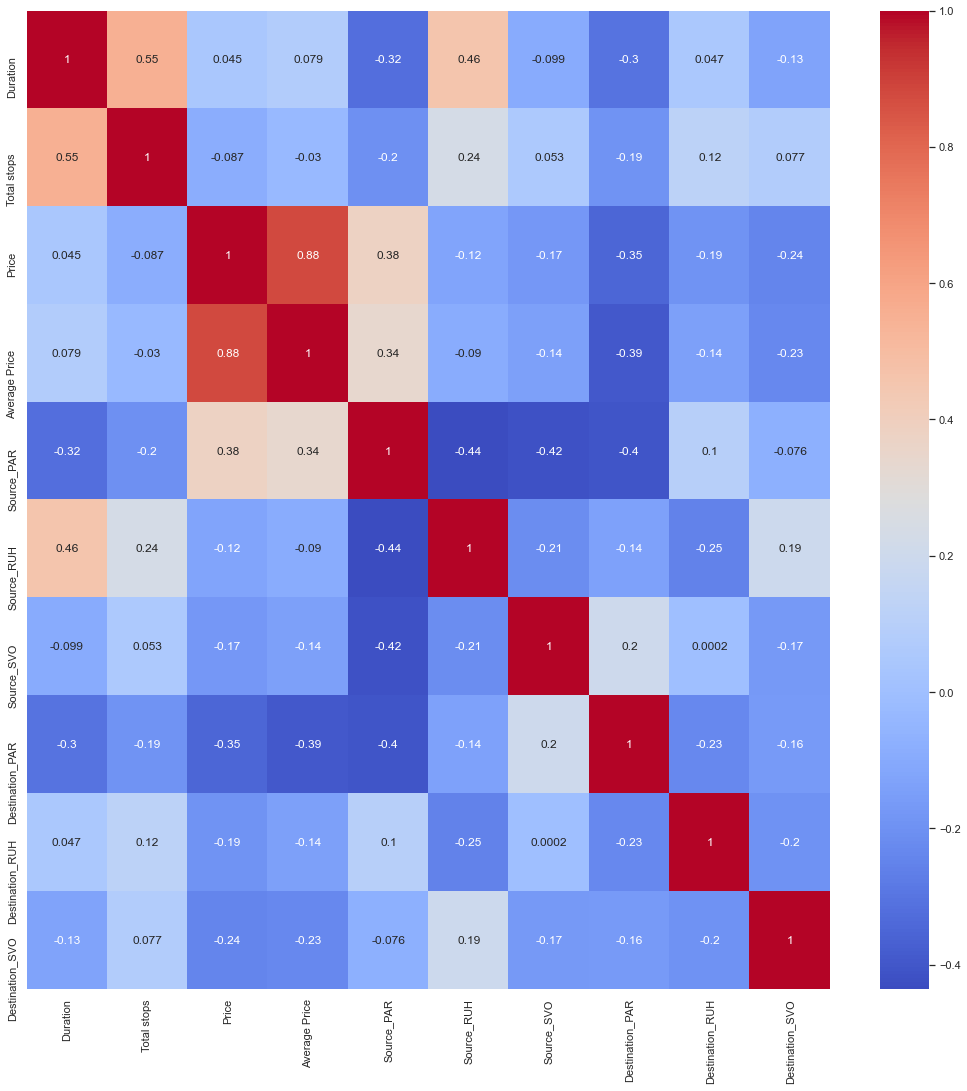

In [40]:
plt.figure(figsize = (18,18))

sns.heatmap(final_df.corr(),annot= True, cmap = "coolwarm")

plt.show()

As we can see from the above figure source_RUH and source_PAR are highly negatively correlated with each other.

In [41]:
# getting feature importance to the target variable "Price".
selection =ExtraTreesRegressor()
selection.fit(X,y)
selection.feature_importances_

array([0.03992517, 0.01459831, 0.7429113 , 0.08711835, 0.00760294,
       0.01356678, 0.02419075, 0.05523358, 0.01485283])

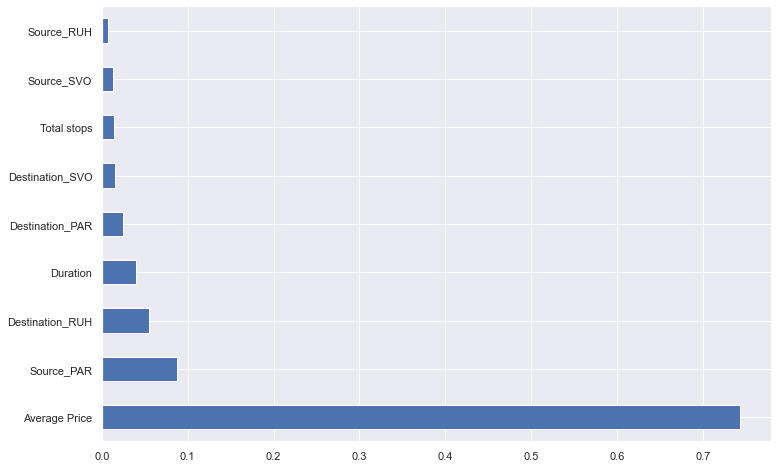

In [42]:
# plotting graph of important features
plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.feature_importances_,index = X.columns)
feat_importances.nlargest(20).plot(kind="barh")
plt.show()

# Modeling: 

Splitting the data

In [43]:
X_train_or, X_test, y_train_or, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_or, y_train_or, test_size=0.25)

In [44]:
def get_metrics(model):
    print(f'Train score {model.score(X_train, y_train)}')
    print(f'Val score {model.score(X_val, y_val)}')
    print("MAE:" , metrics.mean_absolute_error(y_val,model.predict(X_val)))
    print("MSE:" , metrics.mean_squared_error(y_val,model.predict(X_val)))
    print("RMSE:" , np.sqrt(metrics.mean_squared_error(y_val,model.predict(X_val))))

# Linear Regression

In [45]:
lr = LinearRegression()
lr.fit(X_train, y_train)
score = lr.score(X_val, y_val)
get_metrics(lr)

Train score 0.7995769349933366
Val score 0.8057954492206094
MAE: 222.2086250235539
MSE: 145044.14902905398
RMSE: 380.8466213964015


# Polynomial

In [46]:
for degree in [1,2,3,4,5]:
    poly = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    poly.fit(X_train, y_train)
    print("-"*20)
    print("Degree", degree)
    get_metrics(poly)

--------------------
Degree 1
Train score 0.7995769349933366
Val score 0.80579544922061
MAE: 222.20862502356346
MSE: 145044.1490290536
RMSE: 380.846621396401
--------------------
Degree 2
Train score 0.852139836156427
Val score 0.8604142908872954
MAE: 177.11082531682325
MSE: 104251.36956686535
RMSE: 322.87980668797695
--------------------
Degree 3
Train score 0.8712518753329714
Val score 0.8790270776533059
MAE: 157.5599235328996
MSE: 90350.17205784316
RMSE: 300.5830535107446
--------------------
Degree 4
Train score 0.877413591063566
Val score 0.884466169664374
MAE: 147.52413368055346
MSE: 86287.91672412406
RMSE: 293.7480497367158
--------------------
Degree 5
Train score 0.8820395993026247
Val score 0.8885742022381693
MAE: 145.9672004036399
MSE: 83219.78013073064
RMSE: 288.4783876319518


# Lasso

In [47]:
lasso_model = Lasso()
lasso_model.fit(X_train, y_train)
get_metrics(lasso_model)

Train score 0.7993843570972623
Val score 0.8053718647408128
MAE: 220.61210216714622
MSE: 145360.50850759065
RMSE: 381.26173228845124


# Ridge

In [48]:
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)
get_metrics(ridge_model)

Train score 0.7995769202361608
Val score 0.8057937001360076
MAE: 222.19363467936276
MSE: 145045.45535522726
RMSE: 380.8483364217668


# Elasticnet

In [49]:
EN_model = ElasticNet(alpha=1)
EN_model.fit(X_train, y_train)
EN_model.score(X_val, y_val)
get_metrics(EN_model)

Train score 0.7857214385393486
Val score 0.7899880791737728
MAE: 222.2312562532075
MSE: 156850.08523203866
RMSE: 396.04303457078834


# Random Forest

In [50]:
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
get_metrics(rf)

Train score 0.9615118954843789
Val score 0.9544382167641352
MAE: 59.520831461215415
MSE: 34028.39970109252
RMSE: 184.46788257334262


# Feature Scaling

In [51]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

In [52]:
# function to get metrics for scaled features
def scaled_metrics(model):
    print(f'Train score {model.score(X_train_scaled, y_train)}')
    print(f'Val score {model.score(X_val_scaled, y_val)}')
    print("MAE:" , metrics.mean_absolute_error(y_val,model.predict(X_val_scaled)))
    print("MSE:" , metrics.mean_squared_error(y_val,model.predict(X_val_scaled)))
    print("RMSE:" , np.sqrt(metrics.mean_squared_error(y_val,model.predict(X_val_scaled))))

    
## Baseline: Linear Regression

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
score = lr.score(X_val_scaled, y_val)
print("LR")
scaled_metrics(lr)
print("-"*50)

## Polynomial

for degree in [1,2,3,4,5]:
    poly = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    poly.fit(X_train, y_train)
    print("Polynomial - Degree", degree)
    scaled_metrics(poly)
    print("-"*50)

## Lasso

lasso_model = Lasso()
lasso_model.fit(X_train_scaled, y_train)
print("Lasso")
scaled_metrics(lasso_model)
print("-"*50)

## Ridge

ridge_model = Ridge()
ridge_model.fit(X_train_scaled, y_train)
print("Ridge")
scaled_metrics(ridge_model)
print("-"*50)

## ElasticNet

EN_model = ElasticNet(alpha=1)
EN_model.fit(X_train_scaled, y_train)
EN_model.score(X_val_scaled, y_val)
print("ElasticNet")
scaled_metrics(EN_model)
print("-"*50)

## Random Forest
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
print("Random Forest")
scaled_metrics(rf)


LR
Train score 0.7995769349933365
Val score 0.8057954492206096
MAE: 222.2086250235556
MSE: 145044.14902905386
RMSE: 380.84662139640136
--------------------------------------------------
Polynomial - Degree 1
Train score -0.37892809918362946
Val score -0.3785848545014381
MAE: 791.1158927568157
MSE: 1029613.7051527994
RMSE: 1014.6988248504082
--------------------------------------------------
Polynomial - Degree 2
Train score -6.715359366401636
Val score -6.702994030007297
MAE: 1827.2636596371276
MSE: 5753079.469942367
RMSE: 2398.557789577388
--------------------------------------------------
Polynomial - Degree 3
Train score -5.565410967736544
Val score -5.5071393425576005
MAE: 1705.7755210902385
MSE: 4859940.123786768
RMSE: 2204.5271882620927
--------------------------------------------------
Polynomial - Degree 4
Train score -188.04883634634956
Val score -193.67900518580387
MAE: 7796.866866919953
MSE: 145398501.36196858
RMSE: 12058.130093922879
----------------------------------------

Feature scaling was of no use, it did not improve anything.

From the above analysis, we can see that the random forest model performed the best with:

So, we will  select it as our best  model.

In [54]:
X_train_val = pd.concat([X_train,X_val])
y_train_val = pd.concat([y_train,y_val])

rf = RandomForestRegressor()
rf.fit(X_train_val,y_train_val)

print(f'Train score {rf.score(X_train_val, y_train_val)}')
print(f'Test score {rf.score(X_test, y_test)}')
print("MAE:" , metrics.mean_absolute_error(y_test,rf.predict(X_test)))
print("MSE:" , metrics.mean_squared_error(y_test,rf.predict(X_test)))
print("RMSE:" , np.sqrt(metrics.mean_squared_error(y_test,rf.predict(X_test))))

Train score 0.9626261295805452
Test score 0.9515683630513413
MAE: 60.25089534195107
MSE: 35618.019831962665
RMSE: 188.72736905908127


In [55]:
y_train_val_pred = rf.predict(X_train_val)
y_test_pred = rf.predict(X_test)

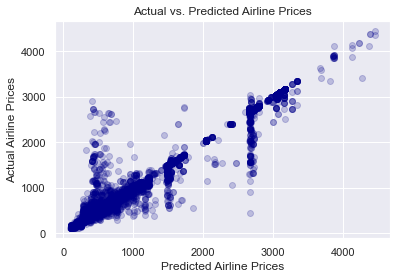

In [56]:
plt.scatter(y_test,y_test_pred,alpha =0.2,color="DarkBlue")
plt.title('Actual vs. Predicted Airline Prices')
plt.xlabel('Predicted Airline Prices')
plt.ylabel('Actual Airline Prices');

As we can see the comparison between actual and predicted airline prices.

# Hyperparameter tunning

In [57]:
# randomized search CV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10]

In [58]:
# create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [59]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, n_jobs = 1)

In [60]:
rf_random.fit(X_train_val,y_train_val)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=25 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=25, total=   5.7s
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=25 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s


[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=25, total=   5.5s
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=25 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=25, total=   6.3s
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=25 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=25, total=   6.2s
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=25 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=25, total=   5.9s
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=25 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=25, total=  10.2s
[CV] n_estimators=300, min_samples_split=5, min_sa

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 10.1min finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   scoring='neg_mean_squared_error', verbose=2)

In [61]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 30}

In [62]:
prediction = rf_random.predict(X_test)

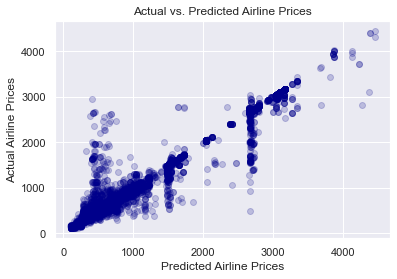

In [63]:
plt.scatter(y_test,prediction,alpha =0.2,color="DarkBlue")
plt.title('Actual vs. Predicted Airline Prices')
plt.xlabel('Predicted Airline Prices')
plt.ylabel('Actual Airline Prices');

In [64]:
print("MAE:" , metrics.mean_absolute_error(y_test,prediction))
print("MSE:" , metrics.mean_squared_error(y_test,prediction))
print("RMSE:" , np.sqrt(metrics.mean_squared_error(y_test,prediction)))


MAE: 62.89012362680102
MSE: 35947.53556287233
RMSE: 189.59835327046574


Therefore, hyperparameter tuning did not improve the model

In [65]:
test_df = pd.DataFrame({
    "Predicted Price" : rf.predict(X_test),
    "Actual Price" : y_test,
}).reset_index(drop = True)

test_df

,Predicted Price,Actual Price
0,749.279206,775.73
1,506.733806,512.27
2,684.983546,397.33
3,333.734672,309.60
4,426.310637,572.53
...,...,...
10015,695.288699,683.47
10016,2691.186100,2682.13
10017,641.976461,631.47
10018,231.181760,232.53


# Saving the model

In [72]:
file = open('rf_flight_prediction.pkl', 'wb')
pkl.dump(rf, file)

In [73]:
model = open('rf_flight_prediction.pkl','rb')
rf_flight_prediction = pkl.load(model)

In [74]:
print(f'R2 score {metrics.r2_score(y_test,rf_flight_prediction.predict(X_test))}')
print("MAE:" , metrics.mean_absolute_error(y_test,rf_flight_prediction.predict(X_test)))
print("MSE:" , metrics.mean_squared_error(y_test,rf_flight_prediction.predict(X_test)))
print("RMSE:" , np.sqrt(metrics.mean_squared_error(y_test,rf_flight_prediction.predict(X_test))))

R2 score 0.9515683630513413
MAE: 60.25089534195107
MSE: 35618.019831962665
RMSE: 188.72736905908127


Therefore, the final model is able to predict flight ticket prices within around ≈ $60.25